### This is in response to one of the reviewers. We fit Marius' data using a white-noise model and a translation invariant model.

The receptive fields were calculated in response to white noise stimuli.

In [40]:
import os
import os.path as path

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import pickle
from scipy import stats
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.decomposition import PCA

from src.data.load_dataset import load_V1_whitenoise
from src.models.weights import V1_covariance_matrix, V1_weights, classical_covariance_matrix, classical_weights

data_dir = path.abspath(path.join(os.getcwd(), "../../"))

#### Load data and select cells with snr > 0.4

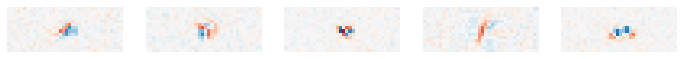

In [41]:
rf_data, snr, dim = load_V1_whitenoise(centered=True)
center = (int(dim[0] / 2), int(dim[1] / 2))
rf = rf_data[snr > 0.4]
num_cells = rf.shape[0]

# normalize for plotting
rf_norm = (rf - np.mean(rf, axis=1).reshape(-1, 1)) / np.std(rf, axis=1).reshape(-1, 1)
fig = plt.figure(figsize=(12, 5))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    i = np.random.randint(len(rf))
    cell_rf = rf_norm[i]
    plt.imshow(cell_rf.reshape(dim), cmap='RdBu')
    plt.clim(-10, 10)
    plt.axis('off')

#### Compute covariance from data and fit optimal hyperparameters to the translation invariant model.

Set the localization parameter $s = \infty$.

In [42]:
# compute data covariance
cov_data = rf.T @ rf
cov_data *= cov_data.shape[1] / np.trace(cov_data)

# find params that minimize frobenius norm difference between data and covariance model
def frob_norm_diff(x):
    cov_model = V1_covariance_matrix(dim, size=100000, spatial_freq=x, center=center, scale=1)
    return la.norm(cov_data - cov_model)

x0 = 2
minimize_diff = minimize(frob_norm_diff, x0, method='BFGS', tol=1e-4)
freq_min = minimize_diff.x[0]
norm = minimize_diff.fun / la.norm(cov_data)
print(f'Optimal params: norm: {norm:.4f}, f={freq_min:.2f}')

Optimal params: norm: 0.9727, f=0.73


#### Generate covariance matrices for data and model

(-0.5, 503.5, 503.5, -0.5)

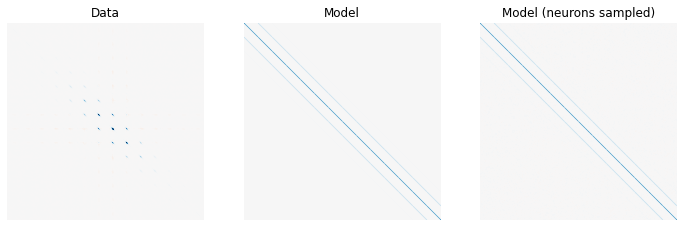

In [43]:
# model
cov_model = V1_covariance_matrix(dim, 100000, freq_min, center=center, scale=1)

# cov from sampled neurons
W = V1_weights(num_cells, dim, 100000, freq_min, center=center, scale=1)
cov_sampled_neurons = W.T @ W
cov_sampled_neurons *= cov_sampled_neurons.shape[0] / np.trace(cov_sampled_neurons)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(131)
plt.title('Data')
plt.imshow(cov_data, cmap='RdBu')
plt.clim(-8, 8)
plt.axis('off')
# plt.xlim(120, 420)
# plt.ylim(120, 420)

ax = fig.add_subplot(132)
plt.title('Model')
plt.imshow(cov_model, cmap='RdBu')
plt.clim(-1, 1)
plt.axis('off')
# plt.xlim(120, 420)
# plt.ylim(120, 420)

ax = fig.add_subplot(133)
plt.title('Model (neurons sampled)')
plt.imshow(cov_sampled_neurons, cmap='RdBu')
plt.clim(-1, 1)
plt.axis('off')
# plt.xlim(120, 420)
# plt.ylim(120, 420)
# plt.savefig('reports/figures/cov_mat_fitted_Marius_whitenoise.pdf')

In [44]:
## save results
covariance = {'data': cov_data, 'model': cov_model, 'finite': cov_sampled_neurons}
translation_invariant = {'covariance': covariance}

#### Compute covariance from data and fit optimal hyperparameters to the white noise model.

In [45]:
cov_model = classical_covariance_matrix(dim, scale=1)
norm = la.norm(cov_model - cov_data) / la.norm(cov_data)
print(f'Optimal params: norm: {norm:.4f}')

Optimal params: norm: 0.9835


(-0.5, 503.5, 503.5, -0.5)

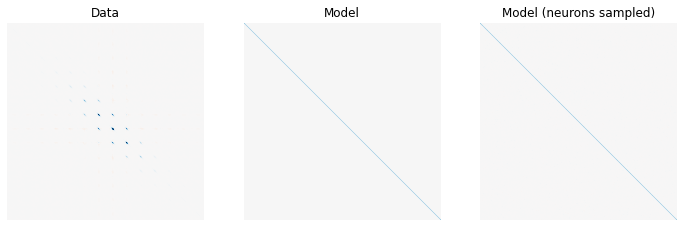

In [46]:
# cov from sampled neurons
W = classical_weights(num_cells, dim, scale=1)
cov_sampled_neurons = W.T @ W
cov_sampled_neurons *= cov_sampled_neurons.shape[0] / np.trace(cov_sampled_neurons)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(131)
plt.title('Data')
plt.imshow(cov_data, cmap='RdBu')
plt.clim(-8, 8)
plt.axis('off')
# plt.xlim(120, 420)
# plt.ylim(120, 420)

ax = fig.add_subplot(132)
plt.title('Model')
plt.imshow(cov_model, cmap='RdBu')
plt.clim(-1, 1)
plt.axis('off')
# plt.xlim(120, 420)
# plt.ylim(120, 420)

ax = fig.add_subplot(133)
plt.title('Model (neurons sampled)')
plt.imshow(cov_sampled_neurons, cmap='RdBu')
plt.clim(-1, 1)
plt.axis('off')
# plt.xlim(120, 420)
# plt.ylim(120, 420)
# plt.savefig('reports/figures/cov_mat_fitted_Marius_whitenoise.pdf')

In [48]:
## save results
covariance = {'data': cov_data, 'model': cov_model, 'finite': cov_sampled_neurons}
random = {'covariance': covariance}

results = {'random': random, 'translation_invariant': translation_invariant}

save_dir = data_dir + '/models/results/covariance_analysis'
if not path.exists(save_dir):
    os.makedirs(save_dir)
with open(save_dir + '/v1_wn_covariance_null_models.pickle', 'wb') as file:
    pickle.dump(results, file)